$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 4: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Spectrally-Normalized Wasserstein GANs

One of the prevailing approaches for improving training stability for GANs is to use a technique called [Spectral Normalization](https://arxiv.org/pdf/1802.05957.pdf) to normalize the largest singular value of a weight matrix so that it equals 1.
This approach is generally applied to the discriminator's weights in order to stabilize training. The resulting model is sometimes referred to as a SN-GAN.
See Appendix A in the linked paper for the exact algorithm. You can also use pytorch's `spectral_norm`.

Another very common improvement to the vanilla GAN is known a [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (WGAN). It uses a simple modification to the loss function, with strong theoretical justifications based on the Wasserstein (earth-mover's) distance.
See the tutorial or [here](https://developers.google.com/machine-learning/gan/loss) for a brief explanation of this loss function.

One problem with generative models for images is that it's difficult to objectively assess the quality of the resulting images.
To also obtain a quantitative score for the images generated by each model,
we'll use the [Inception Score](https://arxiv.org/pdf/1606.03498.pdf).
This uses a pre-trained Inception CNN model on the generated images and computes a score based on the predicted probability for each class.
Although not a perfect proxy for subjective quality, it's commonly used a way to compare generative models.
You can use an implementation of this score that you find online, e.g. [this one](https://github.com/sbarratt/inception-score-pytorch) or implement it yourself.

You would gain a **Bonus** if you also adress [Gradient Penalty](https://arxiv.org/pdf/1704.00028.pdf), as we saw in the tutorial that it could improve the robustness of the GAN and essentially improve the results


Based on the linked papers, add Spectral Normalization and the Wassertein loss to your GAN from HW3.
Compare between:
- The baseline model (vanilla GAN)
- SN-GAN (vanilla + Spectral Normalization)
- WGAN (using Wasserstein Loss)
- Optional: SN+WGAN, i.e. a combined model using both modifications.
- Bonus: WGAN+GP and SN+WGAN+GP

As a dataset, you can use [LFW](http://vis-www.cs.umass.edu/lfw/) as in HW3 or [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), or even choose a custom dataset (note that there's a dataloder for CelebA in `torchvision`). 

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis between the baseline and the other models. Compare:
  - Subjective quality (show multiple generated images from each model)
  - Inception score (can use a subset of the data).
- You should show substantially improved subjective visual results with these techniques.

## Implementation

**TODO**: This is where you should write your explanations and implement the code to display the results.
See guidelines about what to include in this section.

## Imports of essential packages

In [1]:
# general
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt

# pytorch related
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

# current directory related imports
import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

# all project's modules
from project.gan import *
from project.gan_dataloader import *
from project.gan_hyperparameters import *
from project.gan_training import *

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Notes-
- Each model was trained for 200 epochs.
- Each model output was evaluaed by the FID score.
- Source code located under- project/
- Relevant output files (FID scores & generated images without checkopoints) are located under- project/generated_data
- 'load_generated_data=**True**' was added in advance to all *Train()* calls. In order to train the models please change it to **False**.
- in case of training, must use GPU.

## Loading data into pytorch dataset

In [2]:
ds_train = MyDataSet()
dataset = ds_train.ds_gwb

File C:\Users\alon2\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\alon2\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\alon2\.pytorch-datasets\lfw/George_W_Bush


## GAN
###### Uses the same architecture from part 2

In [3]:
print(Discriminator(in_size=[3,256,256]).to(device))
print(Generator(512).to(device))

Discriminator(
  (cnn): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout2d(p=0.3, inplace=False)
      (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (6): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(128, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Dropout2d(p=0.3, inplace=False)
      (10): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (11): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (12): BatchNorm2d(256, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
      (13): ReLU()
      (14): Dropout2d(p=0.3, in

#### Training

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'n_critic': 1, 'c': 0.0}
*** Loading final checkpoint file project_checkpoints/gan_final instead of training
Best fid score is: 808.4785160203573

*** Images Generated from best model:


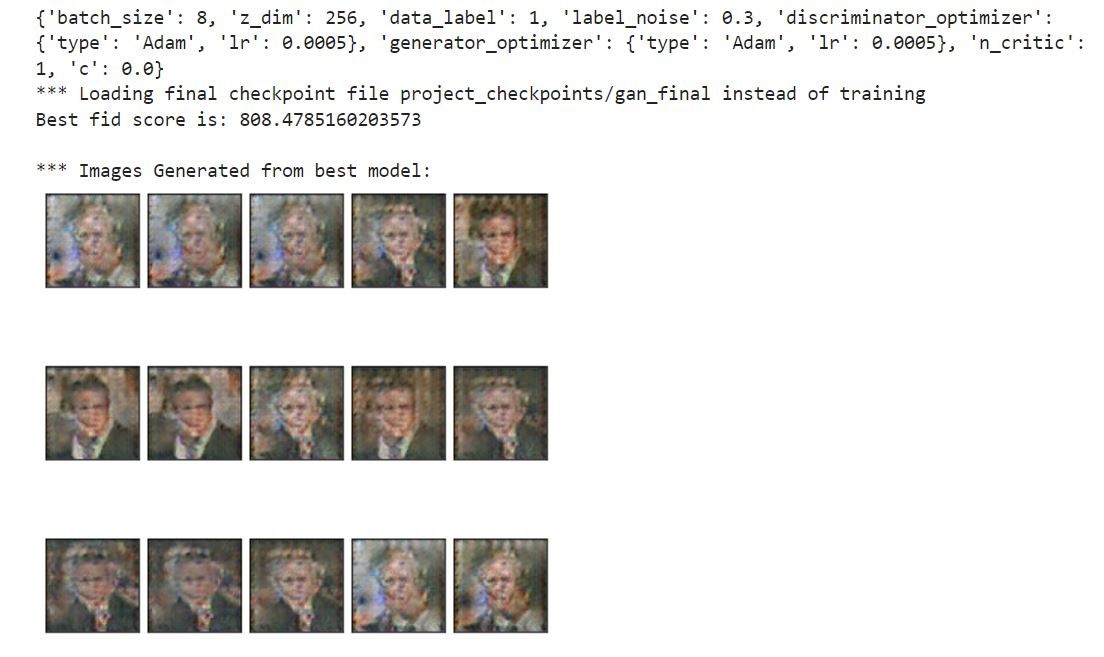

In [4]:
GANTrainer = Train(name='gan',dataset=dataset, device=device, load_generated_data=True).train(200)

## GAN with spectral normalized weights
###### The weights of the discriminator's CNNs are normalized using 'spectral_norm' implementation from torch.nn.utils

In [5]:
print(SNDiscriminator(in_size=[3,256,256], out_channels=256).to(device))
print(Generator(512).to(device))

SNDiscriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout2d(p=0.3, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (11): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(256, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout2d(p=0.3, inplace=False)
    (15): Conv2d(256, 256, kernel_size

#### Training

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'n_critic': 1, 'c': 0.0}
*** Loading final checkpoint file project_checkpoints/sngan_final instead of training
Best fid score is: 395.3704723645333

*** Images Generated from best model:


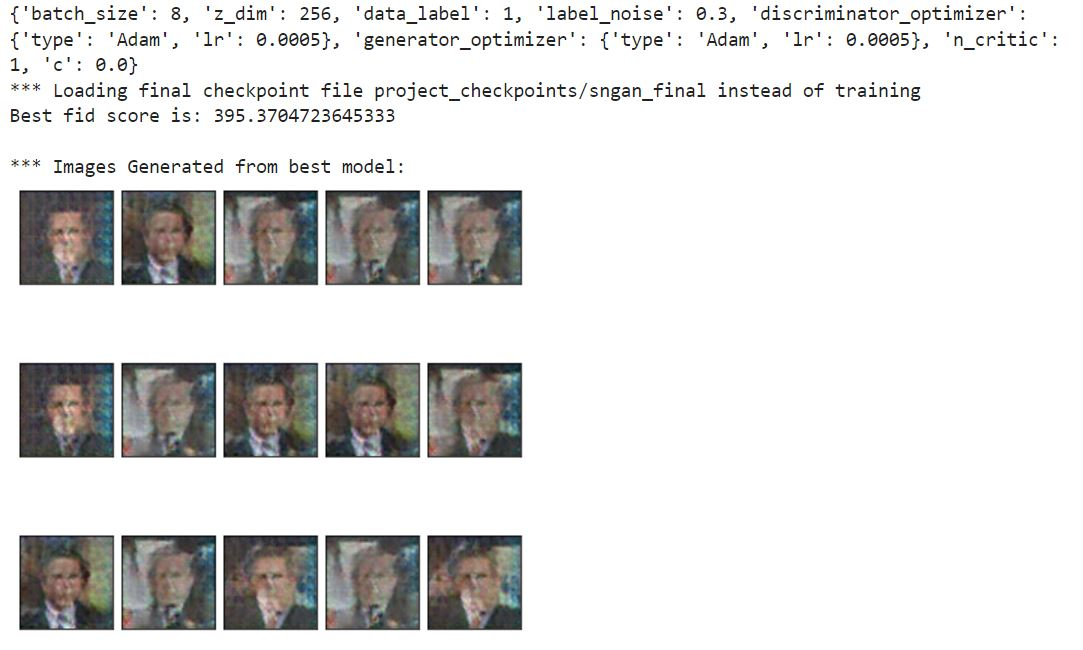

In [6]:
SNGANTrainer = Train(name='sngan',dataset=dataset, device=device, load_generated_data=True).train(200)

## Wasserstein GAN
###### Using different architectures for both generator and discriminator

In [7]:
print(WganDiscriminator(in_size=[3,256,256]).to(device))
print(WganGenerator(512).to(device))

WganDiscriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
WganGenerator(
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

#### Training

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'RMSprop', 'lr': 0.0005}, 'generator_optimizer': {'type': 'RMSprop', 'lr': 0.0005}, 'n_critic': 1, 'c': 0.01}
*** Loading final checkpoint file project_checkpoints/wgan_final instead of training
Best fid score is: 27.87501741786278

*** Images Generated from best model:


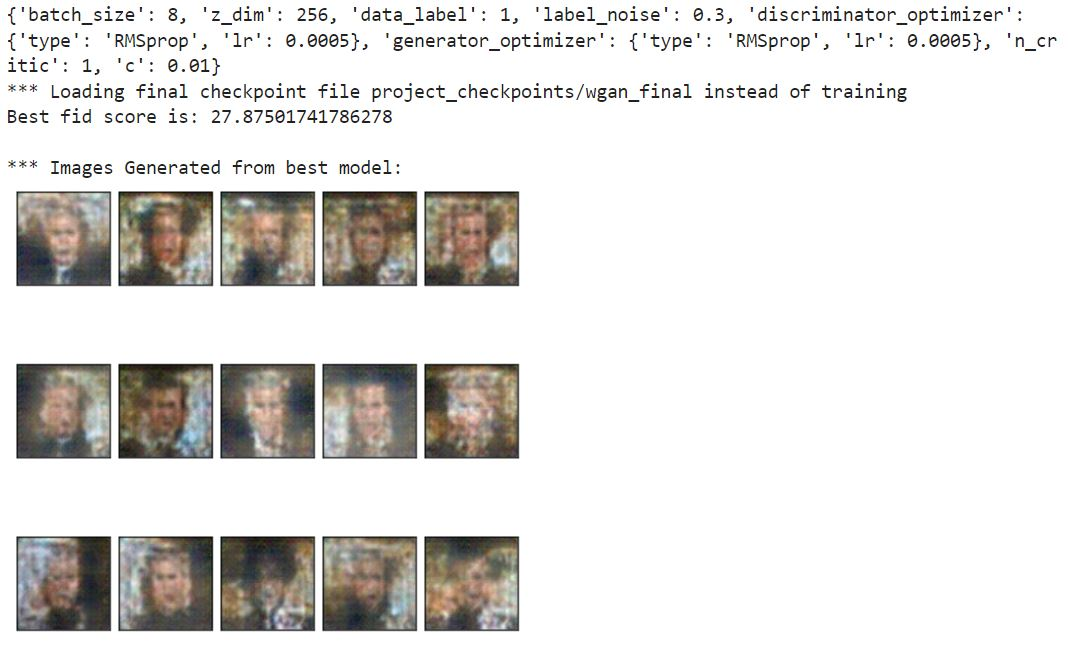

In [8]:
WGANTrainer = Train(name='wgan',dataset=dataset, device=device, load_generated_data=True).train(200)

## Wasserstein GAN with spectral normalizd weights
###### A combination of the Wasserstein GAN from above and the discriminator's CNNs normalized using 'spectral_norm' implementation from torch.nn.utils

#### Training

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'RMSprop', 'lr': 0.0002}, 'generator_optimizer': {'type': 'RMSprop', 'lr': 0.0002}, 'n_critic': 1, 'c': 0.01}
*** Loading final checkpoint file project_checkpoints/snwgan_final instead of training
Best fid score is: 74.56782702982547

*** Images Generated from best model:


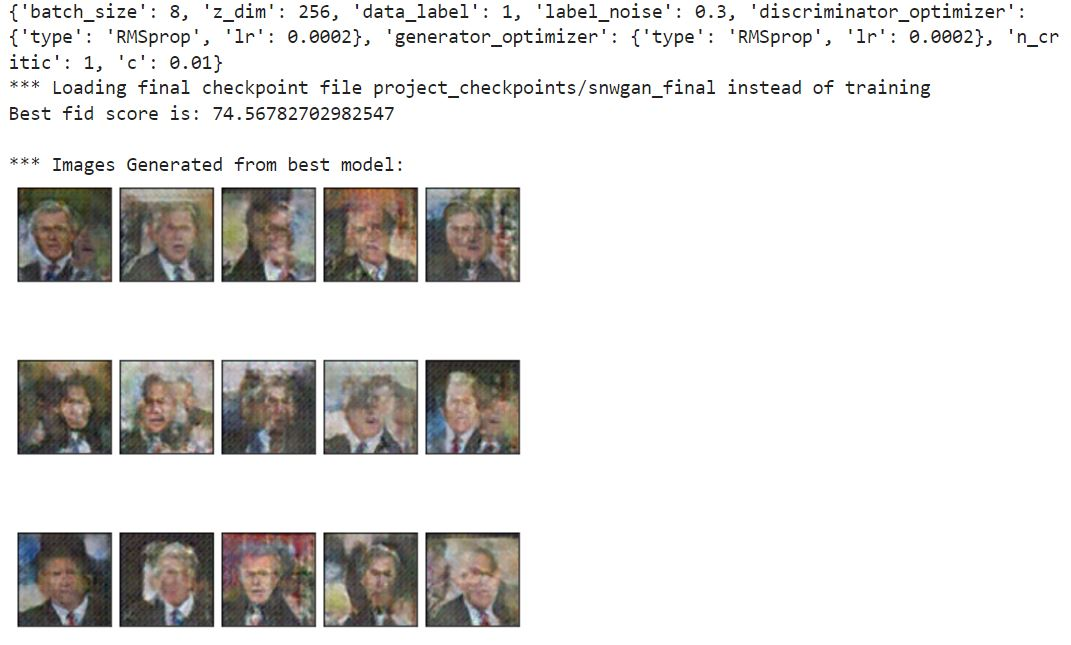

In [9]:
SNWGANTrainer = Train(name='snwgan',dataset=dataset, device=device, load_generated_data=True).train(200)

# Conclusion

- Visualized results-

    1. We can clearly see an improvement as we move from a basic GAN or wasserstein gan implementations to the same architectures but with spectral normalized weights.
    
    2. Basic GAN compared with Wasserstein GAN- The second got us smoother but less distorted images.
    
    2. When looking at the Spectral normalized Wasserstein GAN compared to the basic GAN we notice a big improvement of the results- generated images are much clearer and less distorted. Small objects looks more sharp and clear (the tie for example).
    
    
    
    
- FID score-

    The FID score- 
    1. Basic GAN - 808 
    2. Spectral normalized GAN - 395
    3. Wasserstein GAN - 28
    4. ** Spectral normalized Wasserstein GAN - 74
    
    This Confirms the claims from above that as we proceed with the architectires, the results got better and better.
    
** The FID score of the Spectral normalized Wasserstein GAN was varied in each training phase (best results we saw was 37)- Unlike the other architectires which gave more stable results.